![Logo](../assets/logo.png)

Made by **Domonkos Nagy**

[<img src="../assets/open_button.png">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/9.%20On-policy%20Control/mountain_car.ipynb)

# Mountain Car

The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. In order to achieve this,
the car must first climb up a little on the oppisite side of the hill, otherwise it won't be able to build up enough acceleration to reach the goal.

<img src="assets/mountain_car.gif" width="500"/>

The state space of this environment is continuous. The state consists of two floats:

- The position of the car along the x-axis $([-1.2, 0.6])$
- The velocity of the car $([-0.07, 0.07])$

The starting position is picked randomly from the $[-0.6 , -0.4]$ range, while the starting velocity is always $0$.
There are 3 discrete actions: left, right, and no acceleration. The reward is simply -1 on each time step, encouraging the agent to reach the goal as quickly as possible.
Termination occurs when the car reaches the goal on the right, or the episode gets truncated after 200 steps.

We will use *tile coding* as our function approximator, in the form of a "Tiled Q-table", wich is adapted from the "Tiled value-table" from earlier, but instead of the $V$-function,
it approximates the $Q$-function. The learning algorithm is going to be *Episodic Semi-gradient Sarsa*, an on-policy method for continuous problems.

- Documentation for the Mountain Car environment: https://gymnasium.farama.org/environments/classic_control/mountain_car/

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import pickle
from IPython import display
import time

In [2]:
env = gym.make('MountainCar-v0')  # Creating the environment

In [3]:
LOW = env.observation_space.low
HIGH = env.observation_space.high
N_ACTIONS = env.action_space.n

print(f'N_ACTIONS: {N_ACTIONS}\n')
print('\tPos.  Vel.')
print(f'LOW:\t{LOW}')
print(f'HIGH:\t{HIGH}')

N_ACTIONS: 3

	Pos.  Vel.
LOW:	[-1.2  -0.07]
HIGH:	[0.6  0.07]


In [4]:
# Argmax function that breaks ties randomly
def argmax(arr):
    arr_max = np.max(arr)
    return np.random.choice(np.where(arr == arr_max)[0])

## The Tiled Q-Table

We can easily adapt the tiled value-table from earlier to approximate the $Q$-function. The number of actions is concatenated to the shape of the table,
so we have separate action-values for each tile in each tiling. The argument of the `__getitem__` and `__setitem__` methods is now a tuple of `(state, action)`,
and instead of a state-value, they return a state-action value.
Finally, in order to be able select the optimal action for each state, an `argmax` function is defined.

In [5]:
class TiledQTable:
    def __init__(self, offsets, n_actions, n_bins):
        self.tilings = []
        self.n_tilings = len(offsets)
        self.n_actions = n_actions
        n_dims = len(offsets[0])

        # Create tilings
        for offset in offsets:
            tiling = [np.linspace(LOW[dim], HIGH[dim], n_bins + 1)[1:-1] + offset[dim] for dim in range(n_dims)]
            self.tilings.append(tiling)

        # Initialize Q-table
        shape = (self.n_tilings, ) + (n_bins, ) * n_dims + (n_actions, )
        self.q_table = np.zeros(shape)

    def __getitem__(self, args):
        state = args[0]
        action = args[1]
        val = 0

        # Sum up values in all tilings
        for i, tiling in enumerate(self.tilings):
            ind = [i]
            for dim in range(len(state)):
                ind.append(np.searchsorted(tiling[dim], state[dim]))
            ind.append(action)
            val += self.q_table[tuple(ind)]

        return val

    def __setitem__(self, args, new):
        old = self.__getitem__(args)
        state = args[0]
        action = args[1]

        # Shift values in all tilings
        for i, tiling in enumerate(self.tilings):
            ind = [i]
            for dim in range(len(state)):
                ind.append(np.searchsorted(tiling[dim], state[dim]))
            ind.append(action)
            self.q_table[tuple(ind)] += (new - old) / self.n_tilings

    def argmax(self, state):
        action_values = np.zeros(self.n_actions)       

        # Sum up the values for each action in all tilings
        for i, tiling in enumerate(self.tilings):
            ind = [i]
            for dim in range(len(state)):
                ind.append(np.searchsorted(tiling[dim], state[dim]))
            action_values += self.q_table[tuple(ind)]
            
        return argmax(action_values)

In [6]:
# Hyperparameters
N_TILINGS = 8  # Number of tilings
N_BINS = 8  # Number of bins per dimension per tiling
N_EPISODES = 1_000  # Number of learning steps
ALPHA = 0.1  # Learning rate
GAMMA = 1  # Discount rate
EPSILON = 0.1  # Exploration rate

In [7]:
# Set asymmetrical offsets to avoid artifacts in
# generalization; see Sutton & Barto pg. 218-220 for details
tile_width = (HIGH - LOW) / N_BINS
unit = tile_width / N_TILINGS
offsets = [(unit[0] * i, 3 * unit[1] * i) for i in range(N_TILINGS)]

# Initialize tiled Q-table
tqt = TiledQTable(offsets, N_ACTIONS, N_BINS)

## Episodic Semi-gradient Sarsa

Episodic Semi-gradient Sarsa is a simple learning method, similar to Q-learning. The update rule is defined as:

$$\textbf{w} \leftarrow \textbf{w} + \alpha \left[R+\gamma\hat q(S',A',\textbf{w}) - \hat q(S,A,\textbf{w})\right]\nabla \hat q(S,A,\textbf{w})$$

Where $\hat q$ is the approximate $Q$-function, with $\textbf{w}$ being a vector if its weights.
In our case, $\hat q$ is the tiled Q-table, and its weight vector consists of each of the tile-action-values.
Mathematically, this can be defined as

$$\hat q(s, a, \textbf{w}) := \textbf{w}^\top\textbf{x}(s, a)=
\sum_{i=1}^d w_i\cdot x_i(s,a)$$

Where $\textbf{x}(s,a)$ is a *feature vector*, a mapping of state-action pairs to a vector. The weight vector and the feature vectors have equal sizes,
in this case, it is "$\text{number of tiles across all tilings}\times\text{number of actions}$". The value of $x_i(s,a)$ will be 1 for all $i$ where
$w_i$ is a tile-action-value of action $a$ and a tile that $s$ falls in, and 0 otherwise. For any $s, a$, there will be exactly as many $x_i(s,a)$
of value 1 as many tilings exist.

But what is the gradient? The partial derivatives w.r.t. each of the $w_i$-s are simply $\frac{\partial \hat q(s, a, \textbf{w})}{\partial w_i} = x_i(s,a)$,
so the gradient is basically a zero-vector except for the few positions corresponding to the current state-action pair. Intuitively, this means that we only
shift the weights related to $s, a$, and leave the others alone.

In [8]:
# Epsilon-greedy action selection
def select_action(epsilon, state):
    if np.random.rand() > epsilon:
        return tqt.argmax(state)
    else:
        return env.action_space.sample()

In [9]:
# Training
for episode in trange(N_EPISODES):
    state, _ = env.reset()
    done = False
    action = select_action(EPSILON, state)

    while not done:
        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        target = reward

        if not done:
            new_action = select_action(EPSILON, state)
            target = reward + GAMMA * tqt[new_state, new_action]
            
        tqt[state, action] += ALPHA * (target - tqt[state, action])
        state = new_state
        action = new_action

# Save the tiled Q-table
with open('tqt.bin', 'wb') as f:
    pickle.dump(tqt, f)

  0%|          | 0/1000 [00:00<?, ?it/s]

**Playing the game**: Here we simulate 3 episodes using the resulting policy:

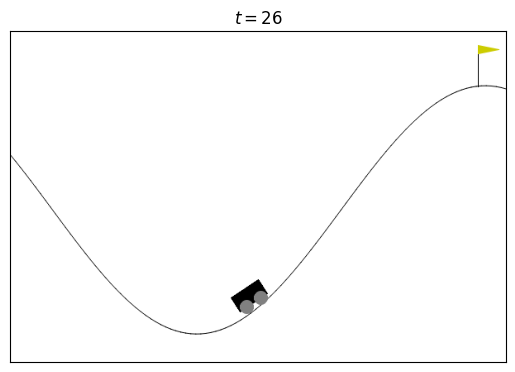

In [ ]:
env = gym.make('MountainCar-v0', render_mode='rgb_array')

# Load the tiled Q-table
with open('tqt.bin', 'rb') as f:
    tqt = pickle.load(f)

plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)

env.reset()
img = plt.imshow(env.render())

# Simulate 3 episodes
for episode in range(3):
    state, _ = env.reset()
    done = False
    t = 0

    img.set_data(env.render())
    plt.title(f"Episode #{episode + 1}")
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(1)
    while not done:
        action = tqt.argmax(state)  # Greedy action selection

        new_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        t += 1

        img.set_data(env.render())
        plt.title(f'$t={t}$')
        display.display(plt.gcf())
        display.clear_output(wait=True)

        if done:
            time.sleep(1)
            break

        state = new_state

env.close()